In [1]:
from bayes_implicit_solvent.solvation_free_energy import get_vacuum_samples
from bayes_implicit_solvent.solvation_free_energy import db, mol_top_sys_pos_list, smiles_list

from openmoltools import utils
from simtk.openmm.app import ForceField
from openmoltools.forcefield_generators import generateResidueTemplate, generateTopologyFromOEMol, gaffTemplateGenerator, generateForceFieldFromMolecules

def create_gaff_sim(mol, pos, gaff_version='gaff'):
    # create force field
    ffxml = generateForceFieldFromMolecules([mol], gaff_version=gaff_version)
    gaff_xml_filename = utils.get_data_filename("parameters/{}.xml".format(gaff_version))
    forcefield = ForceField(gaff_xml_filename)
    forcefield.registerTemplateGenerator(gaffTemplateGenerator)
    
    # register template for molecule
    template, additional_parameters_ffxml = generateResidueTemplate(mol, gaff_version=gaff_version)
    forcefield.registerResidueTemplate(template)
    
    # create simulation
    topology = generateTopologyFromOEMol(mol)
    system = forcefield.createSystem(topology)
    vacuum_sim_gaff, vacuum_traj_gaff = get_vacuum_samples(topology, system, pos, n_samples=2, thinning=2)
    
    return vacuum_sim_gaff

In [2]:
def create_smirnoff_sim(top, sys, pos):
    vacuum_sim_smirnoff, vacuum_traj_smirnoff = get_vacuum_samples(top, sys, pos, n_samples=2, thinning=2)
    return vacuum_sim_smirnoff

In [3]:
mol, top, sys, pos = mol_top_sys_pos_list[-1]

In [4]:
vacuum_sim_gaff = create_gaff_sim(mol, pos, gaff_version='gaff')

100%|██████████| 2/2 [00:00<00:00, 2927.96it/s]


In [5]:
vacuum_sim_smirnoff = create_smirnoff_sim(top, sys, pos)

100%|██████████| 2/2 [00:00<00:00, 3572.66it/s]


In [6]:
torsion_force_gaff = vacuum_sim_gaff.system.getForce(2)
torsion_force_smirnoff = vacuum_sim_smirnoff.system.getForce(2)

In [7]:
torsion_force_gaff.getNumTorsions()

0

In [8]:
torsion_force_smirnoff.getNumTorsions()

0

In [9]:
# remember to handle that corner case if scaling this up!

In [10]:
mol, top, sys, pos = mol_top_sys_pos_list[-100]
vacuum_sim_gaff = create_gaff_sim(mol, pos)
vacuum_sim_smirnoff = create_smirnoff_sim(top, sys, pos)
torsion_force_gaff = vacuum_sim_gaff.system.getForce(2)
torsion_force_smirnoff = vacuum_sim_smirnoff.system.getForce(2)

100%|██████████| 2/2 [00:00<00:00, 2632.13it/s]


In [11]:
[a.name for a in top.atoms()]

['C1', 'C2', 'N1', 'O1', 'H1', 'H2', 'H3', 'H4', 'H5']

In [12]:
torsion_force_gaff.getNumTorsions(), torsion_force_smirnoff.getNumTorsions()

(14, 24)

In [13]:
len(pos)

9

In [14]:
from collections import defaultdict
a = defaultdict(list)
a[0].append(1)
a

defaultdict(list, {0: [1]})

In [15]:
def get_torsion_dict(torsion_force):
    
    torsions = defaultdict(list)
    for i in range(torsion_force.getNumTorsions()):
        a, b, c, d, periodicity, phase, force_constant = torsion_force.getTorsionParameters(i)
        # make sure we can compare torsion tuple equality straightforwardly later
        if d < a:
            (a, b, c, d) = (d, c, b, a)
            phase = - phase
        torsions[(a, b, c, d)].append({'periodicity': periodicity,
                                       'phase': phase,
                                       'force_constant': force_constant,
                                      })
    return torsions

In [16]:
smirnoff_torsions = get_torsion_dict(vacuum_sim_smirnoff.system.getForce(2))

In [17]:
gaff_torsions = get_torsion_dict(vacuum_sim_gaff.system.getForce(2))

In [18]:
len(set(gaff_torsions.keys()).intersection(smirnoff_torsions.keys())) / len(set(gaff_torsions.keys()).union(smirnoff_torsions.keys()))

0.4090909090909091

In [19]:
sorted(list(smirnoff_torsions.keys()))

[(0, 2, 7, 8),
 (0, 2, 8, 7),
 (0, 7, 2, 8),
 (0, 8, 2, 7),
 (1, 0, 2, 3),
 (1, 0, 2, 7),
 (1, 0, 2, 8),
 (1, 0, 3, 2),
 (1, 2, 0, 3),
 (1, 3, 0, 2),
 (2, 0, 1, 3),
 (2, 0, 1, 4),
 (2, 0, 1, 5),
 (2, 0, 1, 6),
 (2, 1, 0, 3),
 (3, 0, 1, 4),
 (3, 0, 1, 5),
 (3, 0, 1, 6),
 (3, 0, 2, 7),
 (3, 0, 2, 8),
 (7, 0, 2, 8),
 (7, 2, 0, 8)]

In [20]:
sorted(list(gaff_torsions.keys()))

[(0, 8, 2, 7),
 (1, 0, 2, 7),
 (1, 0, 2, 8),
 (1, 2, 0, 3),
 (3, 0, 1, 4),
 (3, 0, 1, 5),
 (3, 0, 1, 6),
 (3, 0, 2, 7),
 (3, 0, 2, 8)]

In [21]:
torsions_in_common = sorted(list(set(gaff_torsions.keys()).intersection(smirnoff_torsions.keys())))

In [22]:
torsions_in_common

[(0, 8, 2, 7),
 (1, 0, 2, 7),
 (1, 0, 2, 8),
 (1, 2, 0, 3),
 (3, 0, 1, 4),
 (3, 0, 1, 5),
 (3, 0, 1, 6),
 (3, 0, 2, 7),
 (3, 0, 2, 8)]

In [23]:
torsion = gaff_torsions[torsions_in_common[0]]
torsion

[{'force_constant': Quantity(value=4.6024, unit=kilojoule/mole),
  'periodicity': 2,
  'phase': Quantity(value=3.14159265359, unit=radian)}]

In [24]:
[[t['force_constant'] for t in smirnoff_torsions[torsion_tuple]] for torsion_tuple in torsions_in_common]

[[Quantity(value=0.6973333333333334, unit=kilojoule/mole)],
 [Quantity(value=2.615, unit=kilojoule/mole)],
 [Quantity(value=2.615, unit=kilojoule/mole)],
 [Quantity(value=0.7670666666666667, unit=kilojoule/mole)],
 [Quantity(value=0.0, unit=kilojoule/mole)],
 [Quantity(value=0.0, unit=kilojoule/mole)],
 [Quantity(value=0.0, unit=kilojoule/mole)],
 [Quantity(value=10.46, unit=kilojoule/mole),
  Quantity(value=8.368, unit=kilojoule/mole)],
 [Quantity(value=10.46, unit=kilojoule/mole),
  Quantity(value=8.368, unit=kilojoule/mole)]]

In [25]:
# hmm, that's odd -- why are some of these 0?
# hmm, so a lot of lines in smirnoff99frosst have force constants of exactly zero
# (38 instances of 'k1="0.000"' in the PeriodicTorsionForceDefinition)

In [26]:
[[t['force_constant'] for t in gaff_torsions[torsion_tuple]] for torsion_tuple in torsions_in_common]

[[Quantity(value=4.6024, unit=kilojoule/mole)],
 [Quantity(value=10.46, unit=kilojoule/mole)],
 [Quantity(value=10.46, unit=kilojoule/mole)],
 [Quantity(value=43.932, unit=kilojoule/mole)],
 [Quantity(value=3.3472, unit=kilojoule/mole),
  Quantity(value=0.33472, unit=kilojoule/mole)],
 [Quantity(value=3.3472, unit=kilojoule/mole),
  Quantity(value=0.33472, unit=kilojoule/mole)],
 [Quantity(value=3.3472, unit=kilojoule/mole),
  Quantity(value=0.33472, unit=kilojoule/mole)],
 [Quantity(value=10.46, unit=kilojoule/mole),
  Quantity(value=8.368, unit=kilojoule/mole)],
 [Quantity(value=10.46, unit=kilojoule/mole),
  Quantity(value=8.368, unit=kilojoule/mole)]]

In [27]:
from simtk import unit
import numpy as np
from openmmtools.constants import kB
kT = kB * 298.15 * unit.kelvin

In [28]:
theta = np.linspace(-np.pi, np.pi, 1000) * unit.radian
def evaluate_torsion(theta, periodicity=1, phase=0, force_constant=1):
    return force_constant * (1 + np.cos(periodicity * theta - phase))

def compute_full_torsion(theta, torsion_list):
    U = evaluate_torsion(theta, **torsion_list[0])
    for torsion in torsion_list[1:]:
        U += evaluate_torsion(theta, **torsion)
    return U

def compute_torsion_distribution(theta, torsion_list):
    U = compute_full_torsion(theta, torsion_list)
    q = np.exp(-U / kT)
    Z = np.trapz(q, theta)
    p = q / Z
    return p

Text(0.5,0,'torsion angle')

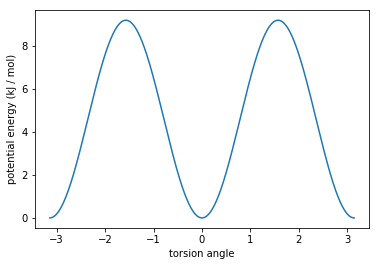

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

U = compute_full_torsion(theta, torsion)
plt.plot(theta, U)
plt.ylabel("potential energy (kJ / mol)")
plt.xlabel('torsion angle')

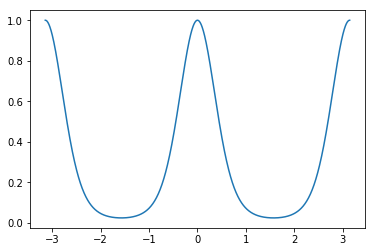

In [30]:
plt.plot(theta, np.exp(-U / kT))

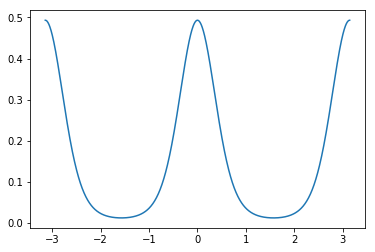

In [31]:
plt.plot(theta, compute_torsion_distribution(theta, torsion))

In [32]:
import mdtraj as md
traj = md.load('/Users/joshuafass/Documents/Github/bayes-implicit-solvent/bayes_implicit_solvent/vacuum_samples/vacuum_samples_116.h5')

def describe_torsion(torsion_tuple):
    atom_names = [a.name for a in traj.top.atoms]
    return ' - '.join(atom_names[i] for i in torsion_tuple)

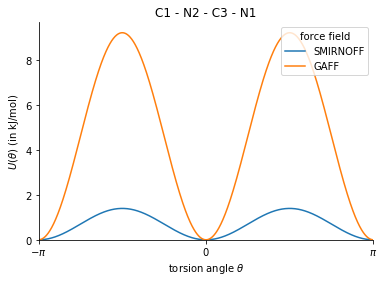

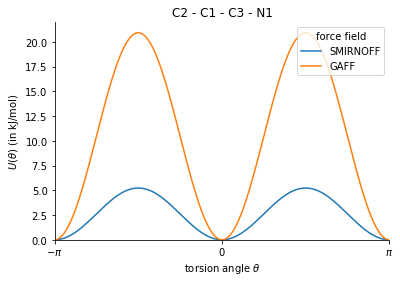

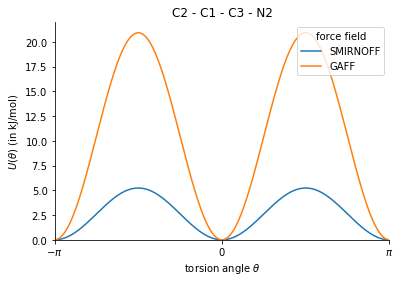

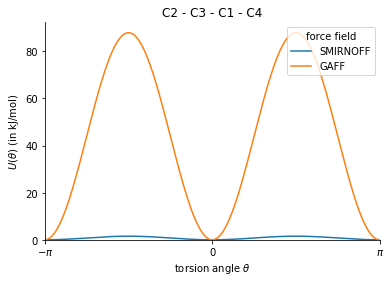

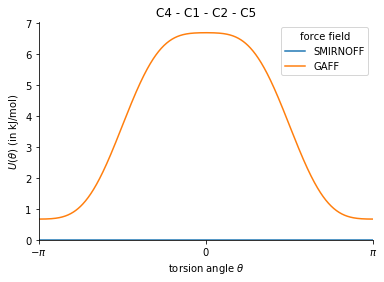

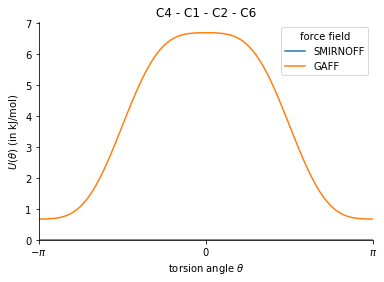

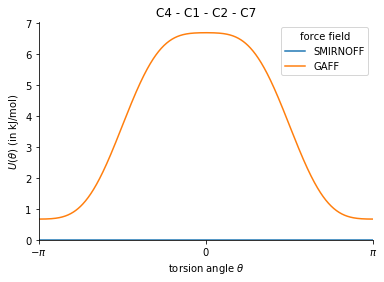

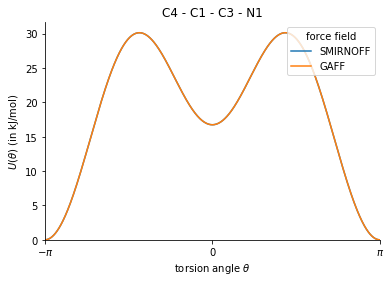

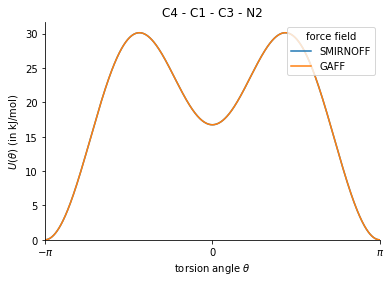

In [33]:
for torsion_tuple in torsions_in_common:
    plt.figure()
    ax = plt.subplot(1,1,1)
    plt.title(describe_torsion(torsion_tuple))
    
    plot_kwargs = {}

    # plot smirnoff
    plt.plot(theta,
             compute_full_torsion(
                 theta,smirnoff_torsions[torsion_tuple]).value_in_unit(
                 unit.kilojoule_per_mole),
             label='SMIRNOFF', **plot_kwargs)

    # plot gaff
    plt.plot(theta,
             compute_full_torsion(
                 theta,gaff_torsions[torsion_tuple]).value_in_unit(
                 unit.kilojoule_per_mole),
             label='GAFF')
        
    plt.legend(title='force field', loc='upper right')
    
    plt.xlim(-np.pi, np.pi)
    plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])
    plt.xlabel(r'torsion angle $\theta$')
    
    plt.ylim(0,)
    #plt.yticks([])
    plt.ylabel(r'$U(\theta)$ (in kJ/mol)')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

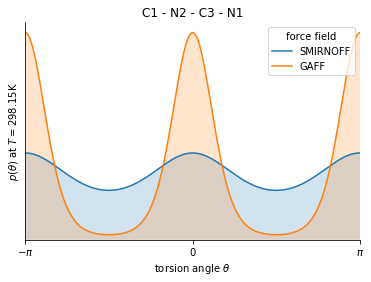

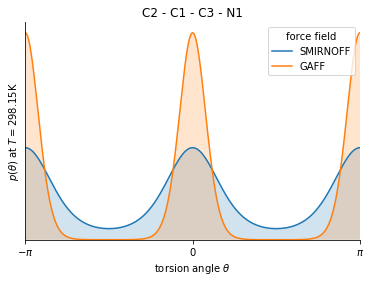

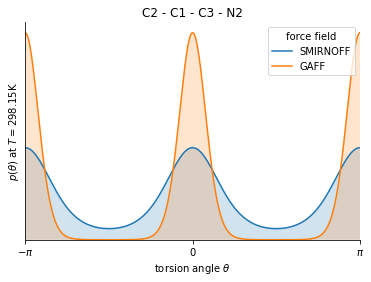

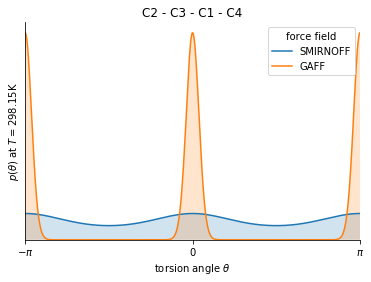

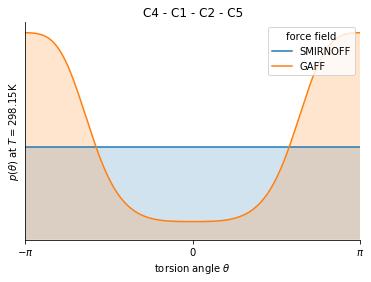

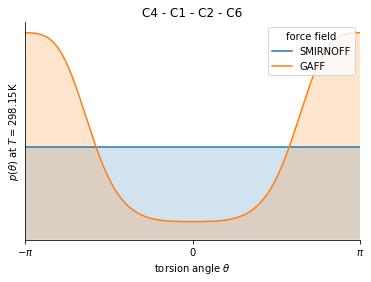

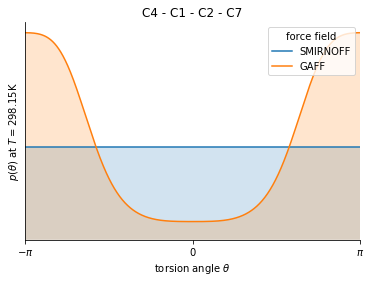

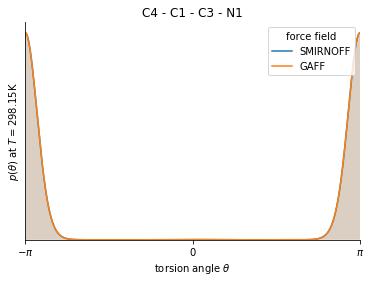

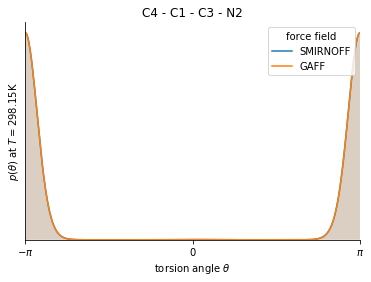

In [34]:
for torsion_tuple in torsions_in_common:
    plt.figure()
    ax = plt.subplot(1,1,1)
    plt.title(describe_torsion(torsion_tuple))
    
    plot_kwargs = {}
    fill_kwargs = {'alpha': 0.2}
    
    
    # plot smirnoff
    plt.plot(theta,
             compute_torsion_distribution(
                 theta,smirnoff_torsions[torsion_tuple]),
             label='SMIRNOFF', **plot_kwargs)
    plt.fill_between(theta,
             compute_torsion_distribution(
                 theta,smirnoff_torsions[torsion_tuple]), **fill_kwargs)
    
    
    # plot gaff
    plt.plot(theta,
             compute_torsion_distribution(
                 theta,gaff_torsions[torsion_tuple]),
             label='GAFF')
    plt.fill_between(theta,
             compute_torsion_distribution(
                 theta,gaff_torsions[torsion_tuple]), **fill_kwargs)
    
    
    
    plt.legend(title='force field', loc='upper right')
    
    plt.xlim(-np.pi, np.pi)
    plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])
    plt.xlabel(r'torsion angle $\theta$')
    
    plt.ylim(0,)
    plt.yticks([])
    plt.ylabel(r'$p(\theta)$ at $T=$298.15K')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

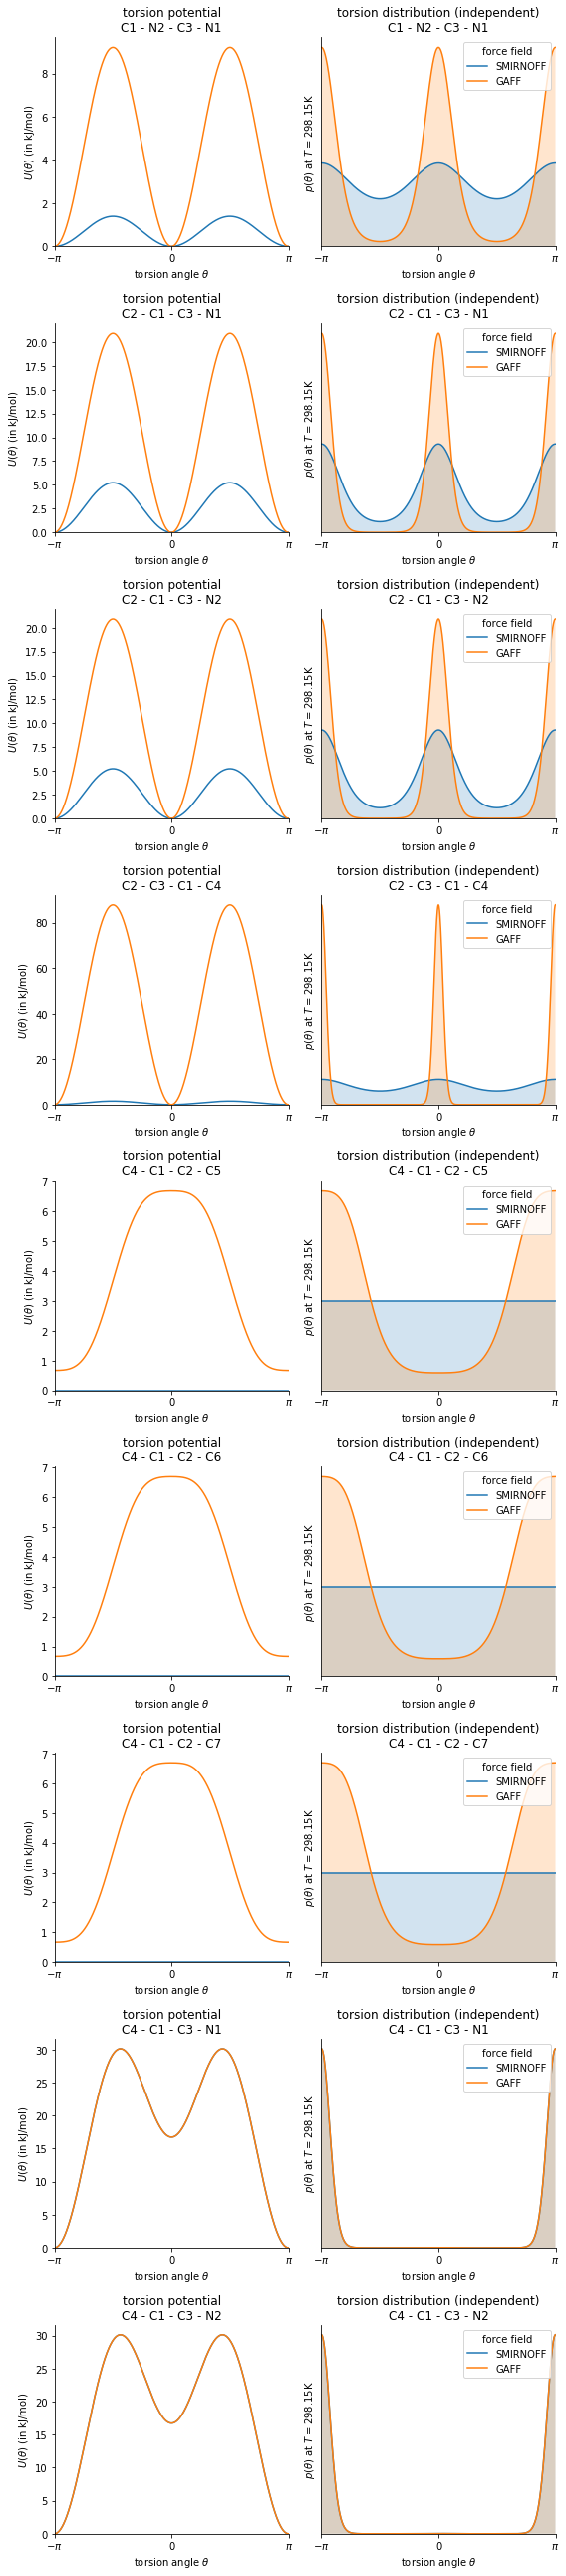

In [35]:
n_rows = len(torsions_in_common)
n_cols = 2
plt.figure(figsize=(4*n_cols,4*n_rows))

i = 0
for torsion_tuple in torsions_in_common:
    # energies
    i += 1
    ax = plt.subplot(n_rows, n_cols, i)
    plt.title('torsion potential\n' + describe_torsion(torsion_tuple))
    
    plot_kwargs = {}

    # plot smirnoff energies
    plt.plot(theta,
             compute_full_torsion(
                 theta,smirnoff_torsions[torsion_tuple]).value_in_unit(
                 unit.kilojoule_per_mole),
             label='SMIRNOFF', **plot_kwargs)

    # plot gaff energies
    plt.plot(theta,
             compute_full_torsion(
                 theta,gaff_torsions[torsion_tuple]).value_in_unit(
                 unit.kilojoule_per_mole),
             label='GAFF', **plot_kwargs)
        
    #plt.legend(title='force field', loc='upper right')
    
    plt.xlim(-np.pi, np.pi)
    plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])
    plt.xlabel(r'torsion angle $\theta$')
    
    plt.ylim(0,)
    #plt.yticks([])
    plt.ylabel(r'$U(\theta)$ (in kJ/mol)')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # distributions
    i += 1
    ax = plt.subplot(n_rows, n_cols, i)
    plt.title('torsion distribution (independent)\n' + describe_torsion(torsion_tuple))
    
    plot_kwargs = {}
    fill_kwargs = {'alpha': 0.2}
    
    # plot smirnoff implied equilibrium distribution
    plt.plot(theta,
             compute_torsion_distribution(
                 theta,smirnoff_torsions[torsion_tuple]),
             label='SMIRNOFF', **plot_kwargs)
    plt.fill_between(theta,
             compute_torsion_distribution(
                 theta,smirnoff_torsions[torsion_tuple]), **fill_kwargs)
    
    
    # plot gaff implied equilibrium distribution
    plt.plot(theta,
             compute_torsion_distribution(
                 theta,gaff_torsions[torsion_tuple]),
             label='GAFF')
    plt.fill_between(theta,
             compute_torsion_distribution(
                 theta,gaff_torsions[torsion_tuple]), **fill_kwargs)
    
    
    
    plt.legend(title='force field', loc='upper right')
    
    plt.xlim(-np.pi, np.pi)
    plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])
    plt.xlabel(r'torsion angle $\theta$')
    
    plt.ylim(0,)
    plt.yticks([])
    plt.ylabel(r'$p(\theta)$ at $T=$298.15K')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('aldicarb-torsions-comparison-gaff.png', bbox_inches='tight')